In [17]:
import spectral as sp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sys

sys.path.append('../')
from preprocessing import *
%matplotlib inline
# matplotlib.use("wxAgg")
# %matplotlib widget

In [24]:
class_labels = ["Not labled", "Normal", "Tumor", "Hypervasculized", "Background"]
data_folder = "../../datasets/helicoid/"
gradeIVpatients = ["008-01", "008-02", "010-03", "012-01", "012-02", "014-01", "015-01", "016-04", "016-05", "017-01", "020-01"]#, "025-02"]  # Is there anything special about these patients?

tumor = []
normal = []
blood = []

for patient in gradeIVpatients:
    
    patient_folder = data_folder + patient
    img = sp.open_image(patient_folder + "/raw.hdr")
    white_ref = sp.open_image(patient_folder + "/whiteReference.hdr")
    dark_ref = sp.open_image(patient_folder + "/darkReference.hdr")
    gt_map = sp.open_image(patient_folder + "/gtMap.hdr")
    gt_map = gt_map.load()
    
    # img = img.asarray() 
    # img = calibrate_img(img, white_ref, dark_ref)
    img = project_img(img, white_ref, dark_ref)

    normal_pixels = np.where(gt_map.asarray()[:,:,0] == 1) # selects pixels which labels belong to tumor class
    for ix in range(len(normal_pixels[0])):
        normal.append(img[normal_pixels[0][ix],normal_pixels[1][ix]])

    tumor_pixels = np.where(gt_map.asarray()[:,:,0] == 2) # selects pixels which labels belong to tumor class
    for ix in range(len(tumor_pixels[0])):
        tumor.append(img[tumor_pixels[0][ix],tumor_pixels[1][ix]])

    blood_pixels = np.where(gt_map.asarray()[:,:,0] == 3) # selects pixels which labels belong to blood class
    for ix in range(len(blood_pixels[0])):
        blood.append(img[blood_pixels[0][ix],blood_pixels[1][ix]])

    print(f"{len(normal_pixels[0])} normal pixels, {len(tumor_pixels[0])} tumor pixels, {len(blood_pixels[0])} blood pixels")

np.savez_compressed(data_folder + "/gradeIV_projected", tumor=tumor, normal=normal, blood=blood)

/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


2295 normal pixels, 1221 tumor pixels, 1331 blood pixels
2187 normal pixels, 138 tumor pixels, 1000 blood pixels
10626 normal pixels, 0 tumor pixels, 2332 blood pixels
4516 normal pixels, 855 tumor pixels, 8697 blood pixels
6553 normal pixels, 3139 tumor pixels, 6041 blood pixels
0 normal pixels, 0 tumor pixels, 64 blood pixels
1251 normal pixels, 2046 tumor pixels, 4089 blood pixels
1178 normal pixels, 0 tumor pixels, 1064 blood pixels
2643 normal pixels, 0 tumor pixels, 452 blood pixels
1328 normal pixels, 0 tumor pixels, 68 blood pixels
1842 normal pixels, 3655 tumor pixels, 1513 blood pixels


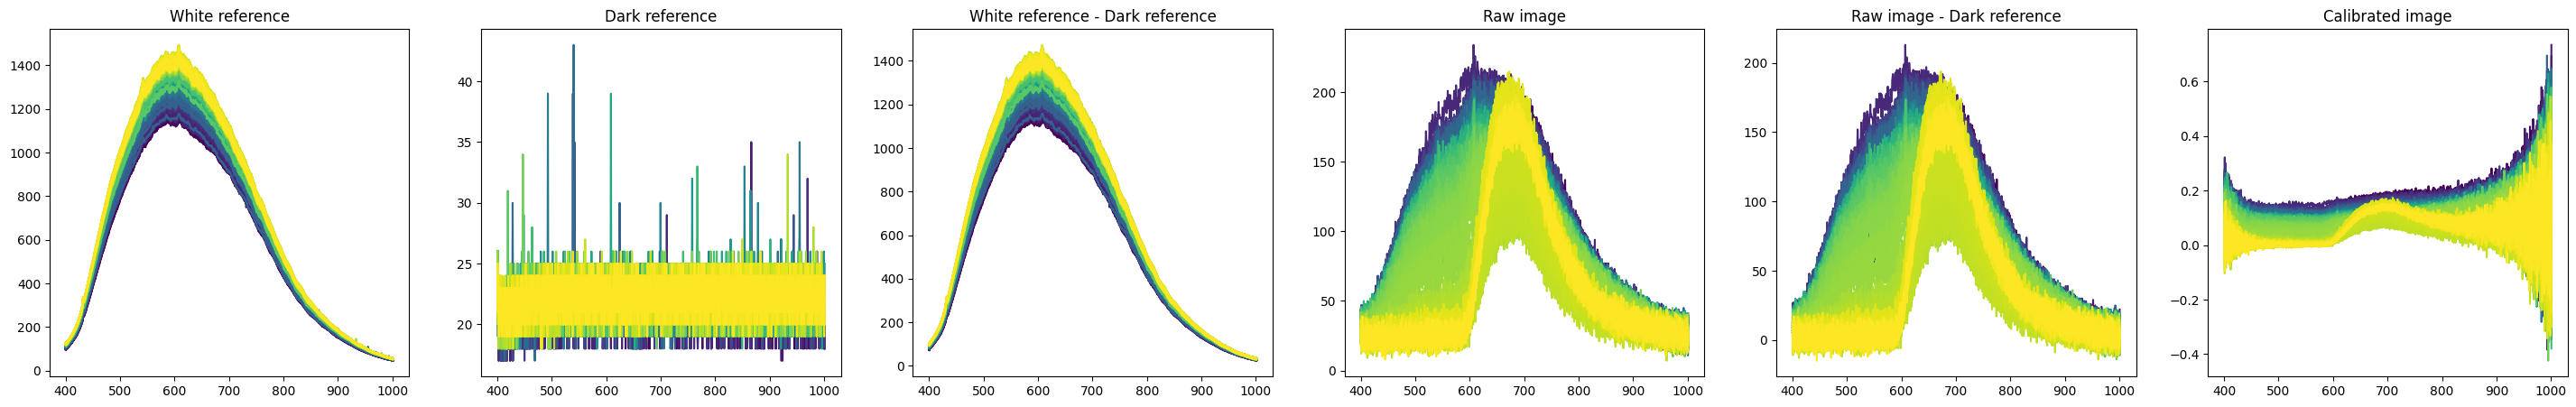

In [65]:
data_folder = "../datasets/helicoid/"
gradeIVpatients = ["008-01"]#, "008-02", "010-03", "012-01", "012-02", "014-01", "015-01", "016-04", "016-05", "017-01", "020-01", "025-02"] 

for n, patient in enumerate(gradeIVpatients):
    
    patient_folder = data_folder + patient + "/"
    img = sp.open_image(patient_folder + "/raw.hdr")
    white_ref = sp.open_image(patient_folder + "/whiteReference.hdr").asarray()
    dark_ref = sp.open_image(patient_folder + "/darkReference.hdr").asarray()

    wavelengths = img.bands.centers
    img = img.asarray().astype(np.int32, casting='safe')

    fig, axs = plt.subplots(1, 6, figsize=(36,5))

    _,N,T = white_ref.shape
    colors = matplotlib.cm.viridis(np.linspace(0, 1, N))

    for i in range(N):
        axs[0].plot(wavelengths, white_ref[0,i,:], color=colors[i])
        axs[1].plot(wavelengths, dark_ref[0,i,:], color=colors[i])
        axs[2].plot(wavelengths, white_ref[0,i,:] - dark_ref[0,i,:], color=colors[i])
        axs[3].plot(wavelengths, img[0,i,:], color=colors[i])
        axs[4].plot(wavelengths, np.subtract(img[0,i,:], dark_ref[0,i,:], dtype=np.float32), color=colors[i])
        axs[5].plot(wavelengths, np.divide(np.subtract(img[0,i,:], dark_ref[0,i,:], dtype=np.float32),np.subtract(white_ref[0,i,:], dark_ref[0,i,:], dtype=np.float32)), color=colors[i])


    axs[0].set_title("White reference")
    axs[1].set_title("Dark reference")
    axs[2].set_title("White reference - Dark reference")
    axs[3].set_title("Raw image")
    axs[4].set_title("Raw image - Dark reference")
    axs[5].set_title("Calibrated image")



## Load data

In [25]:
pixel_data = np.load(data_folder + "gradeIV_projected.npz")

class_labels = ["Normal", "Tumor", "Blood"]
bands = sp.open_image(data_folder + "008-01/raw.hdr").bands.centers # load example image to get band centers

def preprocess(data):
    data, band_centers = band_removal(data, [450.0, 900.0], bands)
    data = smooth_spectral(data)
    # data = normalize_spectral_interval(data)
    return data, band_centers

normal = pixel_data['normal']
normal, band_centers = preprocess(normal)

tumor = pixel_data['tumor']
tumor, band_centers = preprocess(tumor)

blood = pixel_data['blood']
blood, band_centers = preprocess(blood)

print(tumor.shape, normal.shape, blood.shape)

(11054, 618) (34419, 618) (26651, 618)


### Average per-class distribution over multiple images

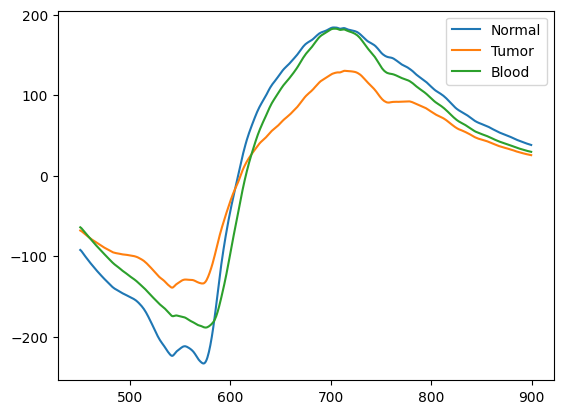

In [26]:
plt.figure()
plt.plot(band_centers, np.mean(normal, axis=0), label="Normal")
plt.plot(band_centers, np.mean(tumor, axis=0), label="Tumor")
plt.plot(band_centers, np.mean(blood, axis=0), label="Blood")
plt.legend()

#### Weights of intra-class PCA

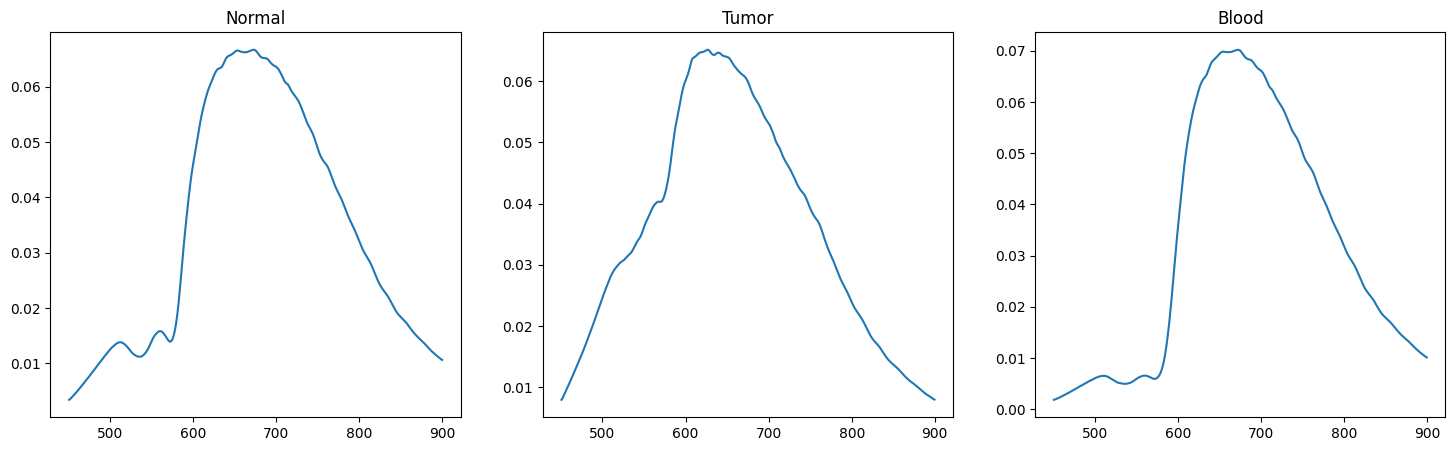

In [22]:
n_components = 5
pca = PCA(n_components=n_components)

plt.figure(figsize=(18,5))
# # perform PCA for each class and plot the weights
for i, data in enumerate([normal, tumor, blood]):
    pca.fit(data)
    plt.subplot(1,3,i+1)
    plt.title(class_labels[i])
    for j in range(1):
        plt.plot(band_centers, pca.components_[j])

#### Inter-class PCA and t-SNE

[0.92395526 0.04582017]
[0.9441547  0.03676154]
[0.9392147  0.03503678]
[0.9013757 0.0659645]


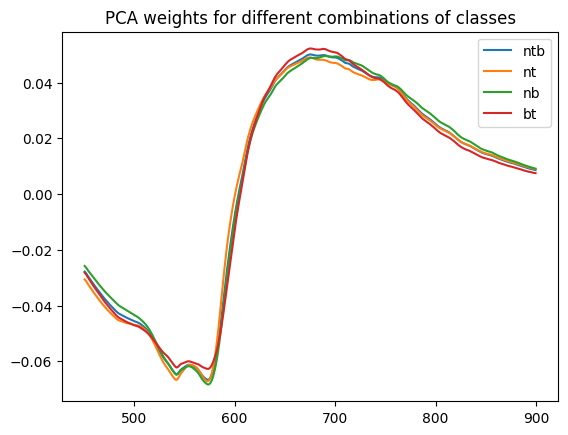

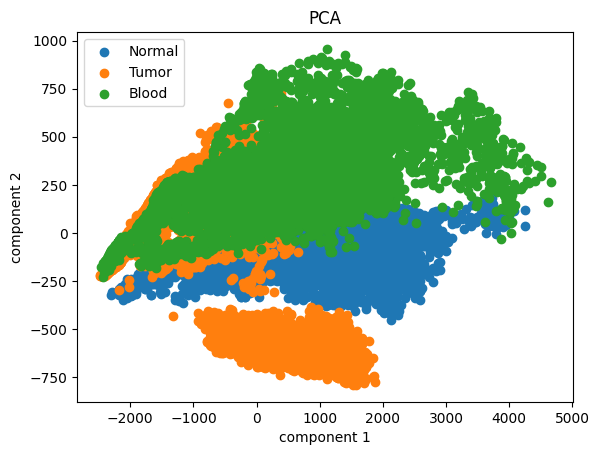

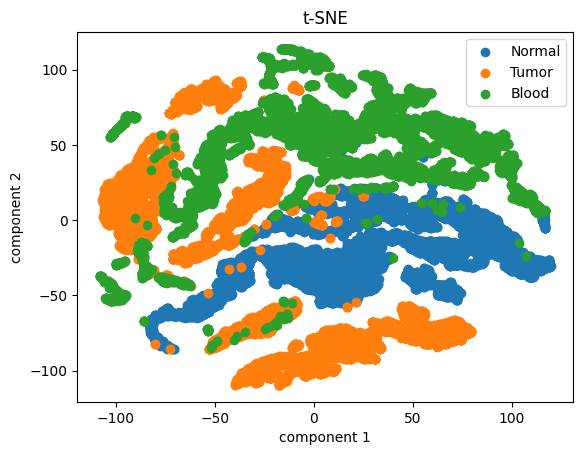

In [27]:
nsamples = 10000

# set seed
np.random.seed(0)
idx_N = np.random.choice(normal.shape[0], nsamples, replace=False)
N = normal[idx_N]
idx_T = np.random.choice(tumor.shape[0], nsamples, replace=False)
T = tumor[idx_T]
idx_B = np.random.choice(blood.shape[0], nsamples, replace=False)
B = blood[idx_B]

N_and_T_and_B = np.concatenate((N, T, B))
N_and_T = np.concatenate((N, T))
N_and_B = np.concatenate((N, B))
B_and_T = np.concatenate((B, T))

pca = PCA(2)
plt.figure()
pca.fit(N_and_T_and_B)
print(pca.explained_variance_ratio_)
plt.plot(band_centers, pca.components_[0], label="ntb")
pca.fit(N_and_T)
print(pca.explained_variance_ratio_)
plt.plot(band_centers, pca.components_[0], label="nt")
pca.fit(N_and_B)
print(pca.explained_variance_ratio_)
plt.plot(band_centers, pca.components_[0], label="nb")
pca.fit(B_and_T)
print(pca.explained_variance_ratio_)
plt.plot(band_centers, pca.components_[0], label="bt")
plt.legend()
plt.title("PCA weights for different combinations of classes")

ntb = pca.fit_transform(N_and_T_and_B)


tsne = TSNE(n_components=2)
ntb_tsne = tsne.fit_transform(N_and_T_and_B)

Y = np.repeat([0,1,2], nsamples)
plt.figure()
for i in range(3):
    plt.scatter(ntb[Y==i, 0], ntb[Y==i, 1], label=class_labels[i])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('PCA')
plt.legend()

plt.figure()
for i in range(3):
    plt.scatter(ntb_tsne[Y==i, 0], ntb_tsne[Y==i, 1], label=class_labels[i])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('t-SNE')
plt.legend()


# pca = PCA(3)
# ntb = pca.fit_transform(N_and_T_and_B)

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# for i in range(1,4):
#     ax.scatter(ntb[Y==i,0], ntb[Y==i,1], ntb[Y==i,2], label=class_labels[i], marker='.', s=50)
# ax.set_xlabel('component 1')
# ax.set_ylabel('component 2')
# ax.set_zlabel('component 3')
# plt.legend()


c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: Use

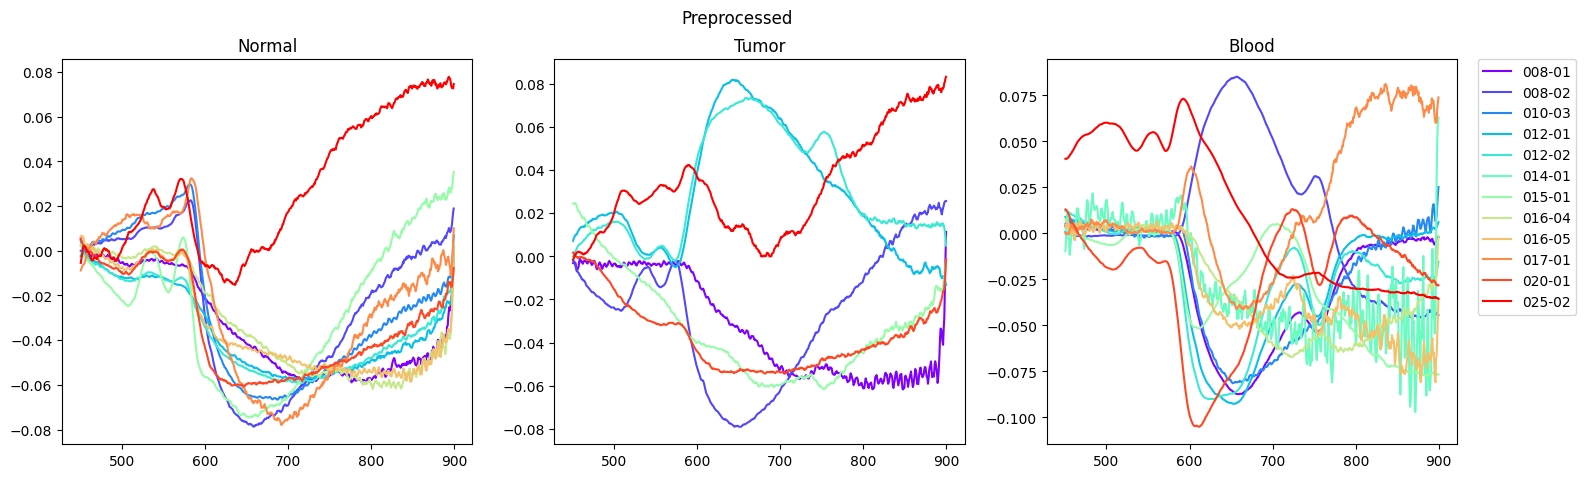

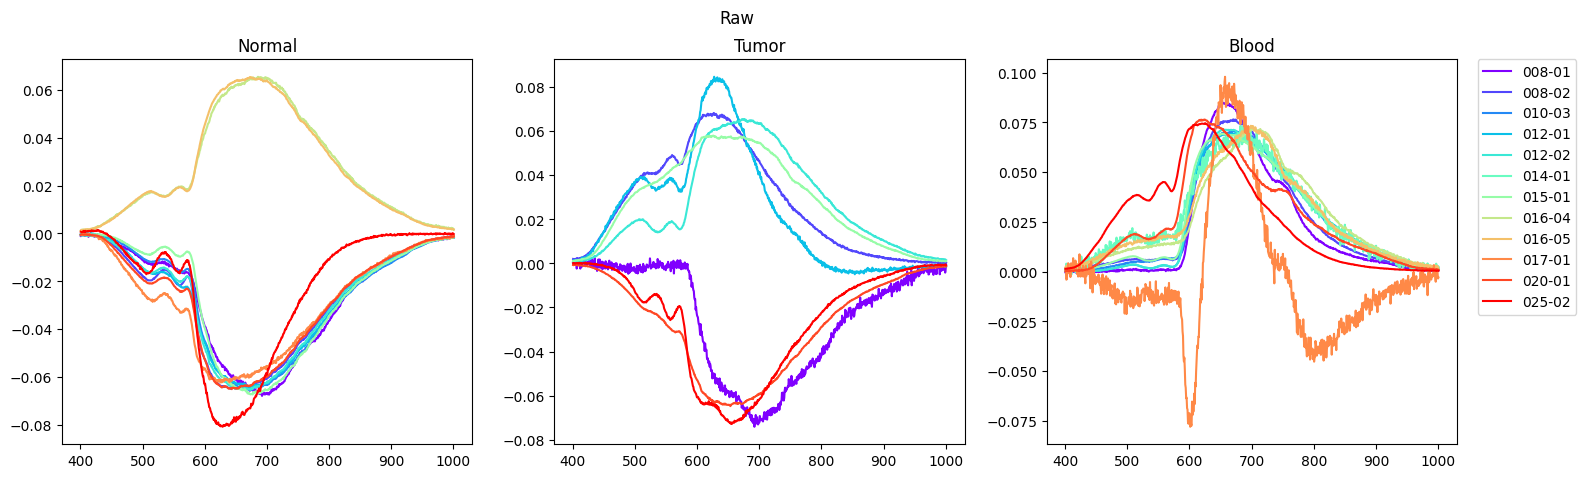

In [6]:
class_labels = ["Not labled", "Normal", "Tumor", "Hypervasculized", "Background"]
data_folder = "helicoid/"
gradeIVpatients = ["008-01", "008-02", "010-03", "012-01", "012-02", "014-01", "015-01", "016-04", "016-05", "017-01", "020-01", "025-02"] 
class_ids = [1, 2, 3]

fig1, axs1 = plt.subplots(1, len(class_ids), figsize=(18,5))
fig2, axs2 = plt.subplots(1, len(class_ids), figsize=(18,5))
colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(gradeIVpatients)))

for n, patient in enumerate(gradeIVpatients):
    
    patient_folder = data_folder + patient + "/"
    img = sp.open_image(patient_folder + "/raw.hdr")
    white_ref = sp.open_image(patient_folder + "/whiteReference.hdr")
    dark_ref = sp.open_image(patient_folder + "/darkReference.hdr")
    gt_map = sp.open_image(patient_folder + "/gtMap.hdr")
    
    img_processed = calibrate_img(img, white_ref, dark_ref, average_ref_pixels=True)
    img_processed, band_centers = band_removal(img_processed, [450.0, 900.0], img.bands.centers)
    img_processed = smooth_spectral(img_processed)
    img_processed = normalize_spectral_interval(img_processed)
    # img_processed = normalize_spectral_interval_mean(img_processed, class_wise=True, gt_map=gt_map)k


    pca = PCA(2)

    for i, class_id in enumerate(class_ids):
        mask = np.where(gt_map.asarray()[:,:,0] == class_id)
        if len(mask[0]) == 0:
            axs1[i].plot([], [])  # Plot an empty line to consume a color
            axs2[i].plot([], []) 
            continue

        class_pixels = img_processed[mask]
        pca.fit(img_processed[mask])
        axs1[i].plot(band_centers, pca.components_[0], color=colors[n], label=patient)
        
        class_pixels = img.asarray()[mask]
        pca.fit(img.asarray()[mask])
        axs2[i].plot(img.bands.centers, pca.components_[0], color=colors[n], label=patient)
    
fig1.suptitle("Preprocessed")
axs1[0].set_title("Normal")
axs1[1].set_title("Tumor")
axs1[2].set_title("Blood")
axs1[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

fig2.suptitle("Raw")
axs2[0].set_title("Normal")
axs2[1].set_title("Tumor")
axs2[2].set_title("Blood")
axs2[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)